In [1]:
# 导入 pandas 库，用于数据处理和分析，提供 DataFrame 等数据结构
import pandas as pd
# 导入 numpy 库，用于高效的数值计算，支持多维数组和矩阵运算
import numpy as np
# 显式启用 sklearn 实验性的迭代插补器功能，必须在使用 IterativeImputer 前导入
from sklearn.experimental import enable_iterative_imputer
# 从 sklearn 中导入 IterativeImputer，用于基于机器学习的缺失值迭代插补
from sklearn.impute import IterativeImputer
# 从 sklearn 中导入支持向量机分类器 SVC，用于监督学习分类任务
from sklearn.svm import SVC
# 导入随机森林模型
from sklearn.ensemble import RandomForestClassifier
# 从 sklearn.metrics 导入 f1_score 和 precision_recall_curve，用于评估分类模型性能
from sklearn.metrics import f1_score, precision_recall_curve
# 从 lifelines 库导入 CoxPHFitter（Cox 比例风险模型）和 KaplanMeierFitter（生存分析非参数估计）
from lifelines import CoxPHFitter, KaplanMeierFitter
# 导入 matplotlib.pyplot 用于绘图和可视化结果
import matplotlib.pyplot as plt

In [2]:
# 从 catboost 库导入 CatBoostClassifier，一种基于梯度提升的决策树分类器，擅长处理类别特征
from catboost import CatBoostClassifier

In [3]:
# ==========================================
# 1. 构建测试数据 (基于来源中的临床特征 [1, 4, 5])
# ==========================================
np.random.seed(42)
n_samples = 1000
features = [
    'age', 'albumin', 'bilirubin', 'INR', 'platelet', 'AFP', 'PIVKA_II', 
    'tumor_number', 'max_tumor_size', 'cirrhosis', 'ascites'
]
# 补充至30个变量 [2]
for i in range(12, 31): features.append(f'feat_{i}')


df = pd.DataFrame(np.random.randn(n_samples, len(features)), columns=features)
# 模拟治疗分配 (LT 或 SR) [1]
df['actual_treatment'] = np.random.choice(['LT', 'SR'], n_samples, p=[0.2, 0.8])
# 模拟生存时间和事件 (最大随访 120 个月 [6])
df['time'] = np.random.exponential(80, n_samples).clip(1, 120)
df['event'] = np.random.binomial(1, 0.4, n_samples)
# 定义 3 年死亡结局 (os_3y: 1表示3年内死亡) [2, 7]
df['os_3y'] = ((df['time'] <= 36) & (df['event'] == 1)).astype(int)

In [6]:
df.to_pickle('df.pkl')

In [30]:
# ==========================================
# 2. 缺失值处理 (分组合并填补 [7, 8])
# ==========================================
def impute_groups(data):
    # 来源指出 LT 和 SR 组应分别填补以保留组别分布 [8]
    imputer = IterativeImputer(random_state=42) # 基于 Bayesian Ridge [7]
    processed_dfs = []
    for treat in ['LT', 'SR']:
        group = data[data['actual_treatment'] == treat].copy()
        feat_cols = [c for c in features]
        group[feat_cols] = imputer.fit_transform(group[feat_cols])
        processed_dfs.append(group)
    return pd.concat(processed_dfs)

df = impute_groups(df)

In [31]:
# ==========================================
# 3. 训练机器学习模型并优化截断值 [2, 9, 10]
# ==========================================
def get_best_threshold(y_true, y_probs):
    # 寻找使 F1 分数最大化的截断值 [2]
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    return thresholds[np.argmax(f1_scores)]


In [32]:

# LT 组: SVM (来源中 AUROC 0.82) [9, 10]
lt_train = df[df['actual_treatment'] == 'LT']
svm_model = SVC(probability=True, kernel='linear', random_state=42)
svm_model.fit(lt_train[features], lt_train['os_3y'])
lt_probs = svm_model.predict_proba(lt_train[features])[:, 1]
lt_thresh = get_best_threshold(lt_train['os_3y'], lt_probs)


In [ ]:
# SR 组: CatBoost (来源中 AUROC 0.79) [9, 11]
sr_train = df[df['actual_treatment'] == 'SR']
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(sr_train[features], sr_train['os_3y'])
sr_probs = rf_model.predict_proba(sr_train[features])[:, 1]
sr_thresh = get_best_threshold(sr_train['os_3y'], sr_probs)

In [37]:
# ==========================================
# 4. 预测所有人的风险并制定推荐 [12, 13]
# ==========================================
# 对每个患者预测两种方案下的死亡风险
p_lt = svm_model.predict_proba(df[features])[:, 1]
p_sr = rf_model.predict_proba(df[features])[:, 1]

# 实际观察到的风险 p_actual
df['p_actual'] = np.where(df['actual_treatment'] == 'LT', p_lt, p_sr)
# 模型推荐的最低风险 p_ml (推荐更低的一方) [12, 13]
df['p_ml'] = np.minimum(p_lt, p_sr)

In [38]:
df

,age,albumin,bilirubin,INR,platelet,AFP,PIVKA_II,tumor_number,max_tumor_size,cirrhosis,...,feat_27,feat_28,feat_29,feat_30,actual_treatment,time,event,os_3y,p_actual,p_ml
5,0.250493,0.346448,-0.680025,0.232254,0.293072,-0.714351,1.865775,0.473833,-1.191303,0.656554,...,0.013002,1.453534,-0.264657,2.720169,LT,28.301860,1,1,0.204382,0.080000
9,1.441273,-1.435862,1.163164,0.010233,-0.981509,0.462103,0.199060,-0.600217,0.069802,-0.385314,...,0.899600,0.307300,0.812862,0.629629,LT,120.000000,0,0,0.194268,0.050000
10,-0.828995,-0.560181,0.747294,0.610370,-0.020902,0.117327,1.277665,-0.591571,0.547097,-0.202193,...,1.158111,0.791663,0.624120,0.628346,LT,107.481221,0,0,0.166436,0.160000
15,-0.062679,0.955142,-0.985726,0.504047,-0.530258,-0.792873,-0.107030,-1.035242,-0.553649,-1.197878,...,0.576557,0.311250,3.078881,1.119575,LT,120.000000,0,0,0.131276,0.131276
24,0.307802,-1.710168,-1.348185,0.743264,0.170865,-0.183983,0.018434,0.347582,-0.539760,-0.778305,...,0.186767,-0.755383,-0.611518,-1.406661,LT,31.224138,0,0,0.164335,0.164335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,0.285407,-0.029471,-0.063736,-0.253865,0.225613,-1.296345,0.811718,-0.877745,-0.250271,0.330560,...,0.025882,-0.471454,0.246457,-0.086555,SR,45.578106,0,0,0.050000,0.050000
991,0.472768,-0.528675,-1.064920,-0.708869,1.442657,0.955967,1.213379,1.282714,-0.466318,0.295812,...,0.667495,0.213993,-0.559282,0.628809,SR,53.464456,0,0,0.050000,0.050000
994,-1.679899,-0.834530,0.686315,-0.226564,-1.073179,-1.838630,0.733204,0.651602,0.243321,-0.495906,...,-0.020081,0.062369,-0.635557,1.613081,SR,10.806880,0,0,0.020000,0.020000
997,-0.403033,-0.274765,0.140742,0.516083,0.807255,2.255517,0.123496,0.735793,-1.587557,-0.379183,...,0.333122,0.253404,-0.059675,0.860742,SR,22.193388,1,1,0.610000,0.158195


In [39]:

# ==========================================
# 5. 反事实生存分析 [3, 12, 14]
# ==========================================
# A. 拟合基于实际观察的 Cox 模型: h(t) = h0(t) * exp(beta * p_actual) [3]
cph = CoxPHFitter()
cph.fit(df[['time', 'event', 'p_actual']], duration_col='time', event_col='event')
beta = cph.params_['p_actual']

# B. 提取基准累积风险 H0(t)
baseline_hazard = cph.baseline_cumulative_hazard_

# C. 计算反事实生存函数 Si_ML(t) = exp(-H0(t) * exp(beta * p_ml)) [14]
def get_cf_time(p_ml_val):
    eta_ml = beta * p_ml_val
    # 计算生存概率曲线 S(t)
    surv_probs = np.exp(-baseline_hazard.values.flatten() * np.exp(eta_ml))
    # 定义反事实生存时间为 S(t) <= 0.5 的最早时间点 [14]
    median_time_idx = np.where(surv_probs <= 0.5)
    if len(median_time_idx) > 0:
        return baseline_hazard.index[median_time_idx]
    else:
        return 120 # 若未达到则在 120 个月截断 [6]

df['time_ml_guided'] = df['p_ml'].apply(get_cf_time)

In [42]:
beta

np.float64(6.7202830085187095)

d:\Analysis\Anaconda3\envs\datasci\lib\site-packages\lifelines\utils\__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


TypeError: Wrong dtype 'object'.

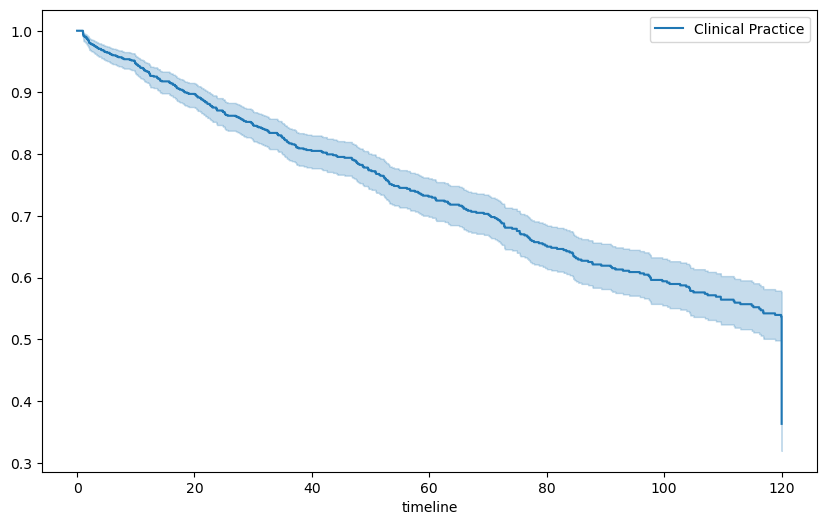

In [41]:

# ==========================================
# 6. 结果可视化 (类似图 3 [15, 16])
# ==========================================
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
# 实际临床结局
kmf.fit(df['time'], df['event'], label='Clinical Practice')
kmf.plot_survival_function()

# 模型引导结局 (反事实)
# 来源假设反事实场景下事件发生点即为推算的中位时间 [6]
kmf.fit(df['time_ml_guided'], np.ones(len(df)), label='ML-Guided Treatment')
kmf.plot_survival_function(linestyle='--')

plt.title("Counterfactual Survival Analysis: ML-Guided vs Clinical Practice")
plt.xlabel("Months elapsed")
plt.ylabel("Probability of survival")
plt.legend()
plt.show()